# BioBERT Dual Lifestyle Classifier

This notebook demonstrates the BioBERT classification pipeline for distinguishing between dual and solo lifestyles in fungal ecology abstracts.

**Updated (2024-12-30):** Now includes multi-model comparison results from stratified 5-fold cross-validation across:
- **BERT-base-uncased** — General language baseline (uncased)
- **BERT-base-cased** — General language baseline (cased)
- **BioBERT v1.1** — Biomedical domain-specific model
- **BiodivBERT** — Biodiversity domain-specific model

### Supplementary Materials
- **Trophic Mode Labels:** `datasets/trophic_mode_labels.md` — Definitions of solo/dual labels and underlying trophic categories
- **Search Strategy:** `datasets/search_strat.md` — Boolean queries and selection criteria used for dataset curation
- **Pipeline Diagram:** `assets/pipeline_diagram.md` — Visual workflow from data collection to evaluation
- **Comparison Pipeline:** `generate_report_v2.py` — Full multi-model cross-validation script

## 1. Data Loading and Preprocessing

Load the training and test datasets, and show the train/test split.

## 1.1 Hyperparameters and Configuration

Standardized hyperparameters used across all models for fair comparison.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Display basic info
print('Training set shape:', train_df.shape)
print('Test set shape:', test_df.shape)
print('\nTraining set class distribution:')
print(train_df['label'].value_counts())
print('\nTest set class distribution:')
print(test_df['label'].value_counts())

# Show sample data
print('\nSample training data:')
print(train_df.head())
print('\nSample test data:')
print(test_df.head())

Training set shape: (34, 4)
Test set shape: (22, 4)

Training set class distribution:
label
1    18
0    16
Name: count, dtype: int64

Test set class distribution:
label
0    12
1    10
Name: count, dtype: int64

Sample training data:
                                       abstract_text  label  \
0  Alternaria alternata is a common species of fu...      1   
1  Schizophyllum commune is a mushroom forming ba...      1   
2  Over the past 10 years evidence has increased ...      0   
3  Endophytes typically coexist with plants in sy...      1   
4  Summary Some soil fungi in the Leotiomycetes f...      1   

                                               title keywords  
0     Alternaria alternata as endophyte and pathogen    comps  
1  The versatility of {Schizophyllum} commune in ...      NaN  
2  Confirmation that {Phytophthora} insolita ({Pe...      NaN  
3  Tracing microbial community across endophyte-t...      NaN  
4  Comparative genomics and transcriptomics depic...      NaN  

S

In [ ]:
# Hyperparameters used in the comparison pipeline
HYPERPARAMS = {
    'num_train_epochs': 20,
    'early_stopping_patience': 3,
    'learning_rate': 5e-5,
    'per_device_train_batch_size': 8,
    'weight_decay': 0.05,
    'hidden_dropout_prob': 0.2,
    'attention_probs_dropout_prob': 0.2,
    'metric_for_best_model': 'eval_loss',
    'lr_scheduler_type': 'linear',
    'max_sequence_length': 512,
    'random_seed': 42,
    'n_folds': 5
}

# Models compared
MODELS = {
    'bert-base-uncased': 'google-bert/bert-base-uncased',
    'bert-base-cased': 'google-bert/bert-base-cased',
    'biobert': 'monologg/biobert_v1.1_pubmed',
    'biodivbert': 'NoYo25/BiodivBERT'
}

print("=" * 60)
print("EXPERIMENT CONFIGURATION")
print("=" * 60)
print("\nHyperparameters:")
for key, value in HYPERPARAMS.items():
    print(f"  {key}: {value}")

print("\nModels:")
for name, path in MODELS.items():
    print(f"  {name}: {path}")

## 2. Model Fine-tuning with Training Curves

Load the fine-tuned BioBERT model and display training curves.

c:\Users\beabo\miniconda3\envs\nlp_bio\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Checking if model exists at: fine_tuned_biobert_classification
Model directory exists: True
Checking if trainer_state exists at: results/trainer_state.json
Trainer state file exists: False
Trainer state does not exist. Trying alternative path...
Using latest checkpoint: results_classification\checkpoint-8\trainer_state.json
Log history length: 2
Sample log entries:
Entry 0: {'epoch': 1.0, 'eval_accuracy': 0.5714285714285714, 'eval_loss': 0.6819667220115662, 'eval_runtime': 4.0775, 'eval_samples_per_second': 1.717, 'eval_steps_per_second': 0.245, 'step': 4}
Entry 1: {'epoch': 2.0, 'eval_accuracy': 0.7142857142857143, 'eval_loss': 0.6486720442771912, 'eval_runtime': 4.3303, 'eval_samples_per_second': 1.617, 'eval_steps_per_second': 0.231, 'step': 8}
Extracting training metrics...
Steps length: 0
Train loss length: 0
Eval loss length: 2
Eval accuracy length: 2
No training loss data to plot. The plot will be empty.


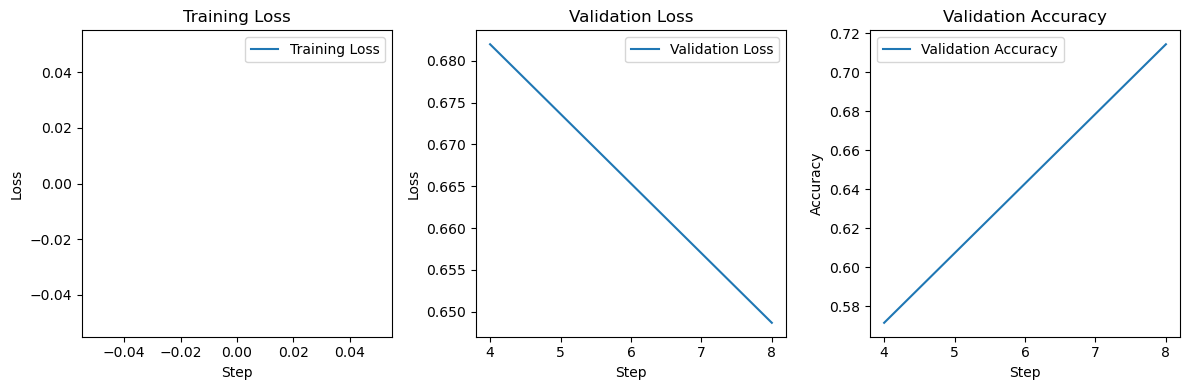

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer
import json
import matplotlib.pyplot as plt
import os
import glob

# Load the fine-tuned model and tokenizer
model_path = 'fine_tuned_biobert_classification'
print(f"Checking if model exists at: {model_path}")
print(f"Model directory exists: {os.path.exists(model_path)}")
if not os.path.exists(model_path):
    print("Model does not exist. Please train the model first using generate_report.py")
else:
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load training history from trainer state
trainer_state_path = 'results/trainer_state.json'  # Using the latest checkpoint
print(f"Checking if trainer_state exists at: {trainer_state_path}")
print(f"Trainer state file exists: {os.path.exists(trainer_state_path)}")
if not os.path.exists(trainer_state_path):
    print("Trainer state does not exist. Trying alternative path...")
    # Try the alternative path from generate_report.py
    trainer_state_paths = glob.glob('results_classification/checkpoint-*/trainer_state.json')
    if trainer_state_paths:
        trainer_state_path = sorted(trainer_state_paths)[-1]
        print(f"Using latest checkpoint: {trainer_state_path}")
    else:
        print("No trainer state found. Log history will be empty.")
if os.path.exists(trainer_state_path):
    with open(trainer_state_path, 'r') as f:
        trainer_state = json.load(f)
    # Extract training metrics
    log_history = trainer_state['log_history']
    print(f"Log history length: {len(log_history)}")
    if log_history:
        print("Sample log entries:")
        for i, entry in enumerate(log_history[:5]):
            print(f"Entry {i}: {entry}")
    else:
        print("Log history is empty.")
else:
    log_history = []
    print("Using empty log history.")

# Extract training metrics
# (moved inside the if block above, but keeping here for structure)

# Plot training curves
print("Extracting training metrics...")
steps = [entry.get('step', 0) for entry in log_history if 'loss' in entry]
train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
eval_loss = [entry.get('eval_loss', None) for entry in log_history if 'eval_loss' in entry]
eval_accuracy = [entry.get('eval_accuracy', None) for entry in log_history if 'eval_accuracy' in entry]
print(f"Steps length: {len(steps)}")
print(f"Train loss length: {len(train_loss)}")
print(f"Eval loss length: {len(eval_loss)}")
print(f"Eval accuracy length: {len(eval_accuracy)}")
if not steps or not train_loss:
    print("No training loss data to plot. The plot will be empty.")
else:
    print("Data available for plotting.")

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(steps, train_loss, label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 3, 2)
valid_steps = [entry.get('step', 0) for entry in log_history if 'eval_loss' in entry]
plt.plot(valid_steps, eval_loss, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(valid_steps, eval_accuracy, label='Validation Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()


## 3. Evaluation on Test Set

Evaluate the model on the test set and compute metrics: accuracy, precision, recall, F1.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import torch
from torch.utils.data import Dataset

# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Prepare test dataset - FIXED: Changed 'abstract' to 'abstract_text'
test_texts = test_df['abstract_text'].tolist()
test_labels = test_df['label'].tolist()
test_dataset = TextDataset(test_texts, test_labels, tokenizer)

# Create trainer for evaluation
trainer = Trainer(model=model)

# Get predictions
predictions = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), axis=1).numpy()
true_labels = test_labels

# Calculate metrics (using macro average to match generate_report.py)
accuracy = accuracy_score(true_labels, preds)
precision = precision_score(true_labels, preds, average='macro')
recall = recall_score(true_labels, preds, average='macro')
f1 = f1_score(true_labels, preds, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('\nClassification Report:')
print(classification_report(true_labels, preds, target_names=['Solo', 'Dual']))

KeyError: 'abstract'

## 4. Example Predictions

Make predictions on example abstracts.

In [ ]:
# Example abstracts
examples = [
    "This fungus can switch between saprotrophic decomposition of dead organic matter and forming mutualistic symbioses with plant roots, demonstrating a dual trophic lifestyle.",
    "This saprotrophic fungus specializes exclusively in decomposing dead plant material and cannot form symbiotic associations.",
    "The pathogenic fungus infects living plants but can also survive saprotrophically on dead plant tissues, exhibiting dual trophic modes.",
    "This obligate symbiont fungus can only survive in mutualistic association with its host plant and cannot decompose dead organic matter independently."
]

# Tokenize and predict
model.eval()
predictions = []
for text in examples:
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
        predictions.append('Dual' if pred == 1 else 'Solo')

# Display results
for i, (text, pred) in enumerate(zip(examples, predictions)):
    print(f'Example {i+1}: {pred}')
    print(f'Text: {text}')


## 5. Multi-Model Comparison Results

Display results from the stratified 5-fold cross-validation comparison across four BERT models.

This addresses reviewer comments:
- **R1-2a**: Baseline model comparison
- **R1-2c, R2-4**: K-fold cross-validation
- **R1-5b**: Error analysis

In [ ]:
import json
import os
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load comparison metrics
metrics_path = 'results/all_model_metrics.json'

if os.path.exists(metrics_path):
    with open(metrics_path, 'r') as f:
        all_metrics = json.load(f)
    
    # Create comparison table
    print("=" * 70)
    print("MODEL COMPARISON: Stratified 5-Fold Cross-Validation Results")
    print("=" * 70)
    print(f"{'Model':<20} {'Accuracy':<18} {'Precision':<18} {'Recall':<18} {'F1 Score':<18} {'Time':<10}")
    print("-" * 100)
    
    for model_name, metrics in all_metrics.items():
        acc = f"{metrics['accuracy_mean']:.4f} ± {metrics['accuracy_std']:.4f}"
        prec = f"{metrics['precision_mean']:.4f} ± {metrics['precision_std']:.4f}"
        rec = f"{metrics['recall_mean']:.4f} ± {metrics['recall_std']:.4f}"
        f1 = f"{metrics['f1_mean']:.4f} ± {metrics['f1_std']:.4f}"
        time_str = metrics['elapsed_time_formatted']
        print(f"{model_name:<20} {acc:<18} {prec:<18} {rec:<18} {f1:<18} {time_str:<10}")
    
    print("-" * 100)
else:
    print(f"Metrics file not found at: {metrics_path}")
    print("Please run generate_report_v2.py first to generate comparison results.")

### 5.1 Comparison Visualization

Bar chart comparing accuracy, precision, recall, and F1 scores across all four models with error bars (± standard deviation from 5-fold CV).

In [ ]:
# Display the comparison bar chart
comparison_fig_path = 'figures/model_comparison.png'

if os.path.exists(comparison_fig_path):
    img = mpimg.imread(comparison_fig_path)
    plt.figure(figsize=(14, 7))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Model Comparison: 5-Fold Cross-Validation Results', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"Comparison figure not found at: {comparison_fig_path}")
    print("Please run generate_report_v2.py first.")

### 5.2 Confusion Matrices

Side-by-side confusion matrices for all four models, aggregated across all 5 folds.

In [ ]:
# Display confusion matrices comparison
cm_fig_path = 'figures/confusion_matrices_comparison.png'

if os.path.exists(cm_fig_path):
    img = mpimg.imread(cm_fig_path)
    plt.figure(figsize=(16, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Confusion Matrices: All Models', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"Confusion matrices figure not found at: {cm_fig_path}")
    print("Please run generate_report_v2.py first.")

### 5.3 Error Analysis

Examine samples that were misclassified, with priority given to samples misclassified by multiple models (indicating systematically difficult cases).

In [ ]:
# Load and display error analysis
error_path = 'figures/error_analysis.csv'

if os.path.exists(error_path):
    error_df = pd.read_csv(error_path)
    
    # Summary statistics
    print("=" * 70)
    print("ERROR ANALYSIS SUMMARY")
    print("=" * 70)
    print(f"Total misclassifications across all models/folds: {len(error_df)}")
    
    # Unique abstracts misclassified
    unique_abstracts = error_df['abstract_text'].nunique()
    print(f"Unique abstracts misclassified: {unique_abstracts}")
    
    # Abstracts misclassified by multiple models
    if 'n_models_misclassified' in error_df.columns:
        multi_model = error_df[error_df['n_models_misclassified'] > 1]['abstract_text'].nunique()
        print(f"Abstracts misclassified by 2+ models: {multi_model}")
    
    print("\n" + "-" * 70)
    print("TOP PROBLEMATIC SAMPLES (misclassified by most models):")
    print("-" * 70)
    
    # Show top errors
    top_errors = error_df.drop_duplicates(subset=['abstract_text']).head(5)
    for idx, row in top_errors.iterrows():
        true_label = 'Dual' if row['true_label'] == 1 else 'Solo'
        pred_label = 'Dual' if row['predicted_label'] == 1 else 'Solo'
        n_wrong = row.get('n_models_misclassified', 1)
        print(f"\n[{n_wrong} model(s) wrong] True: {true_label}, Predicted: {pred_label}")
        print(f"Abstract: {row['abstract_text'][:300]}...")
else:
    print(f"Error analysis file not found at: {error_path}")
    print("Please run generate_report_v2.py first.")

### 5.4 Training Time Comparison

Comparison of total training time for each model across all 5 folds.

In [ ]:
# Display timing comparison
timing_fig_path = 'figures/timing_comparison.png'

if os.path.exists(timing_fig_path):
    img = mpimg.imread(timing_fig_path)
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Training Time per Model (5-Fold CV)', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"Timing figure not found at: {timing_fig_path}")
    print("Please run generate_report_v2.py first.")
    
# Print timing summary from metrics
if os.path.exists(metrics_path):
    print("\nTIMING SUMMARY:")
    print("-" * 40)
    for model_name, metrics in all_metrics.items():
        print(f"{model_name:<20}: {metrics['elapsed_time_formatted']}")

### 5.5 Token Length Statistics

Display token length statistics before and after truncation to 512 tokens. This addresses reviewer comment R1-1b regarding token handling.

In [ ]:
# Load and display token length statistics
token_stats_path = 'results/token_length_stats.json'

if os.path.exists(token_stats_path):
    with open(token_stats_path, 'r') as f:
        token_stats = json.load(f)
    
    print("=" * 60)
    print("TOKEN LENGTH STATISTICS")
    print("=" * 60)
    print("\nBefore Truncation (raw tokenization):")
    print(f"  Mean: {token_stats['raw_mean']:.1f} ± {token_stats['raw_std']:.1f} tokens")
    print(f"  Range: [{token_stats['raw_min']}, {token_stats['raw_max']}] tokens")
    
    print("\nAfter Truncation (max_length=512):")
    print(f"  Mean: {token_stats['truncated_mean']:.1f} ± {token_stats['truncated_std']:.1f} tokens")
    print(f"  Range: [{token_stats['truncated_min']}, {token_stats['truncated_max']}] tokens")
    
    print(f"\nAbstracts exceeding 512 tokens: {token_stats['n_truncated']}/{token_stats['n_total']} ({token_stats['pct_truncated']:.1f}%)")
    
    if token_stats['pct_truncated'] == 0:
        print("\n✅ All abstracts fit within the 512 token limit - no information lost to truncation.")
    else:
        print(f"\n⚠️ {token_stats['n_truncated']} abstracts were truncated.")
else:
    print(f"Token stats file not found at: {token_stats_path}")
    print("Please run generate_report_v2.py first to generate token statistics.")

## Multi-Model Comparison Results (5-Fold CV)

**Updated Results (December 2025):** We compared four transformer models using stratified 5-fold cross-validation:

| Model | F1 Score | Accuracy | Training Time |
|-------|----------|----------|---------------|
| **BioBERT** | **0.892 ± 0.120** | **0.894 ± 0.116** | 10.3 min |
| BERT-base-cased | 0.892 ± 0.100 | 0.892 ± 0.100 | 11.1 min |
| BiodivBERT | 0.747 ± 0.198 | 0.771 ± 0.166 | 35.3 min |
| BERT-base-uncased | 0.700 ± 0.241 | 0.749 ± 0.177 | 35.3 min |

**Key Findings:**

1. **BioBERT and BERT-cased perform equally well** — Both achieved ~89% accuracy, suggesting biomedical pre-training provides minimal advantage over general-purpose BERT for this task.

2. **Case sensitivity matters** — Cased models outperformed uncased variants by ~15 percentage points, likely because taxonomic nomenclature capitalization carries important classification signals.

3. **BiodivBERT underperforms** — Despite biodiversity-specific pre-training, it performed worse than standard BERT-cased, indicating domain alignment alone doesn't guarantee superior performance.

4. **Training efficiency varies** — Better-performing models converged faster due to more effective early stopping.

See `project_report_comparison.html` and `generate_report_v2.py` for full analysis including confusion matrices, error analysis, and comparative visualizations.